# Graph Convolution Network for fMRI Analysis Based on Connectivity Neighborhood

# 1. Configuration

In [1]:
!pip install PyDrive
!pip install keras==2.1.5
!pip install tensorflow==1.4.1
!pip install h5py==2.8.0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import h5py
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1pBNGcBAQt0jdD1AIZQ_EYW9aMf8g-BEu"})
downloaded.GetContentFile('model.py')

from model import *

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarn

# Play with cGCN layer

## Generate a random FC matrix

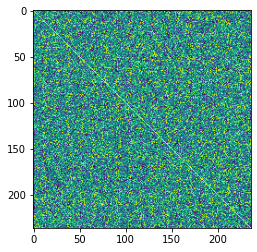

In [3]:
ROI_N = 236
random_FC = np.random.rand(ROI_N, ROI_N)
random_FC[np.diag_indices(ROI_N)] = 1
np.save('FC_random', random_FC)
plt.imshow(random_FC)
plt.show()

## Obtain a k-NN graph

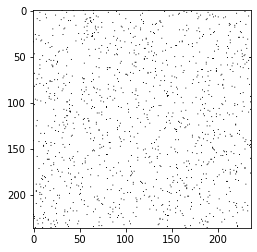

In [4]:
k = 5
kNN = random_FC.argsort(axis=1)[:, ::-1][:, 1:k+1] # copied from "get_model" function of "model.py" file
kNN_vis = np.zeros_like(random_FC)
for i in range(kNN.shape[0]):
    for j in range(kNN.shape[1]):
        kNN_vis[i, kNN[i, j]] = 1
plt.imshow(kNN_vis, cmap='binary')
plt.show()

## Test function of "T_get_edge_feature" and "T_conv_bn_max"

In [5]:
n_frame = 100
ROI_N = 236
input_channel = 1
k = 5

print("B: Batch")
print("T: Time frames of fMRI clips")
print("N: No. of ROIs")
print("K: Directly connected neighbors, defined by the k value of the k-NN graph")
print("C: Channels")

print("                                   (B,   T,   N, K, C)")
input_tmp = tf.placeholder(tf.float32, shape=(None, n_frame, ROI_N, 1, input_channel))
print("Input shape:                      ", input_tmp.shape)
graph_tmp = tf.placeholder(tf.int32, shape=(None, ROI_N, k))
out_tmp = T_get_edge_feature(input_tmp, nn_idx=graph_tmp, k=k)

print("\nGetting the edge feature,")
print("intermediate output shape:        ", out_tmp.shape)

print("\nAfter Convolution (5 kernels) ")
out_tmp = T_conv_bn_max(out_tmp, 5)
print("and max aggregation, the output")
print("shape:                            ", out_tmp.shape)

B: Batch
T: Time frames of fMRI clips
N: No. of ROIs
K: Directly connected neighbors, defined by the k value of the k-NN graph
C: Channels
                                   (B,   T,   N, K, C)
Input shape:                       (?, 100, 236, 1, 1)

Getting the edge feature,
intermediate output shape:         (?, 100, 236, 5, 2)

After Convolution (5 kernels) 
and max aggregation, the output
shape:                             (?, 100, 236, 1, 5)


## Test the function "T_edge_conv"

In [6]:
conv_kernels = [2, 4, 8, 16]

print("                                   (B,   T,   N, C)")
input_tmp0 = tf.placeholder(tf.float32, shape=(None, n_frame, ROI_N, input_channel))
print("Input shape:                      ", input_tmp0.shape)

input_tmp = tf.placeholder(tf.float32, shape=(None, n_frame, ROI_N, 1, input_channel))
print("\nWith the explicit dimension of")
print("directly connected neighbors:      (B,   T,   N, K, C)")
print("Input shape:                      ", input_tmp.shape)

for i, kernel in enumerate(conv_kernels, 1):
    out = input_tmp
    out = T_edge_conv(out, 
                      graph=tf.constant(kNN, dtype=tf.int32), 
                      kernel=kernel, k=k)
    print('\nAfter %d conv layer, output shape: '%i, out.shape)

out = tf.squeeze(out, -2)

print('\nW/o the redundant dimension,       (B,   T,   N, C)')
print('output shape:                     ', out.shape)
print('------------------------------------------------------')
print('\nLike common convolutions')
print('w/ conv kernels:', conv_kernels)
print('                                   (B,   T,   N, C)')
print('input data shape:                 ', input_tmp0.shape)
print('output data shape:                ', out.shape)

                                   (B,   T,   N, C)
Input shape:                       (?, 100, 236, 1)

With the explicit dimension of
directly connected neighbors:      (B,   T,   N, K, C)
Input shape:                       (?, 100, 236, 1, 1)

After 1 conv layer, output shape:  (?, 100, 236, 1, 2)

After 2 conv layer, output shape:  (?, 100, 236, 1, 4)

After 3 conv layer, output shape:  (?, 100, 236, 1, 8)

After 4 conv layer, output shape:  (?, 100, 236, 1, 16)

W/o the redundant dimension,       (B,   T,   N, C)
output shape:                      (?, 100, 236, 16)
------------------------------------------------------

Like common convolutions
w/ conv kernels: [2, 4, 8, 16]
                                   (B,   T,   N, C)
input data shape:                  (?, 100, 236, 1)
output data shape:                 (?, 100, 236, 16)


# Overfit on small random datasets

## Import data

In [10]:
N = 100
n_frames = 100
x_train_random = np.random.normal(0, 1, size=(N, n_frames, ROI_N, 1))
x_test_random = np.random.normal(0, 1, size=(N, n_frames, ROI_N, 1))
print('train data shape:', x_train_random.shape)
print('test data shape:', x_test_random.shape)

num_classes = 2
label_random = np.arange(num_classes).repeat(N // num_classes)
y_train_random_2 = y_test_random_2 = keras.utils.to_categorical(label_random, 2)
print('y_train_random_2 shape:', y_train_random_2.shape)
y_train_random_100 = y_test_random_100 = keras.utils.to_categorical(label_random, 100)
print('y_train_random_100_categories shape:', y_train_random_100.shape)
for label, count in enumerate(y_train_random_2.sum(0)):
    print('Label %d: %d/%d (%.1f%%)'%(label, count, y_train_random_2.shape[0], 100.0 * count / y_train_random_2.shape[0]))

train data shape: (100, 100, 236, 1)
test data shape: (100, 100, 236, 1)
y_train_random_2 shape: (100, 2)
y_train_random_100_categories shape: (100, 100)
Label 0: 50/100 (50.0%)
Label 1: 50/100 (50.0%)


## Get cGCN model

In [8]:
model = get_model(
    graph_path='FC_random.npy', 
    kernels=[8,8,8,16,32,32], 
    k=3, 
    l2_reg=0, 
    dp=0,
    num_classes=num_classes, 
    weight_path=None, 
    skip=[0,0])
model.summary()

model.compile(loss=['categorical_crossentropy'], 
          optimizer=keras.optimizers.Adam(lr=0.001),
          metrics=['accuracy'])

load graph: FC_random.npy
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             (None, 100, 236, 1)  0                                            
__________________________________________________________________________________________________
graph (InputLayer)              (236, 3)             0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, 236, 3)       0           graph[0][0]                      
                                                                 points[0][0]                     
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 100, 236, 3,  0           points[0][0]      

## Training

In [ ]:
hist = model.fit(x_train_random, y_train_random_2,
        shuffle=True,
        batch_size=4,
        validation_data=(x_test_random, y_test_random_2),
        epochs=10)

Best train acc: 1.0
Best test acc: 0.6


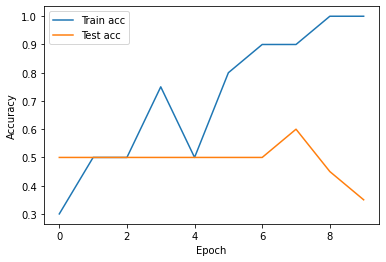

In [ ]:
plt.plot(hist.history['acc'], label='Train acc')
plt.plot(hist.history['val_acc'], label='Test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
print('Best train acc:', max(hist.history['acc']))
print('Best test acc:', max(hist.history['val_acc']))
# Best Train acc: ~100% (random: 50%).
# Best Test acc: ~50% (random: 50%).

# Train and test on HCP dataset

## Get HCP data

In [12]:
downloaded = drive.CreateFile({'id':"1l029ZuOIUY5gehBZCAyHaJqMNuxRHTFc"})
downloaded.GetContentFile('data.h5')
with h5py.File('data.h5', 'r') as f:
    x_train, x_val, x_test = f['x_train'][()], f['x_val'][()], f['x_test'][()]
    y_train, y_val, y_test = f['y_train'][()], f['y_val'][()], f['y_test'][()]


x_train = np.expand_dims(x_train, -1) # (200, 100, 236, 1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)
print ('x_train:', x_train.shape)
print ('x_val:', x_val.shape)
print ('x_test:', x_test.shape)

# Convert class vectors to binary class matrices.
num_classes = 100

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print ('y_train:', y_train.shape)
print ('y_val:', y_val.shape)
print ('y_test:', y_test.shape)

x_train: (2400, 100, 236, 1)
x_val: (1200, 100, 236, 1)
x_test: (1200, 100, 236, 1)
y_train: (2400, 100)
y_val: (1200, 100)
y_test: (1200, 100)


## Get FC matrix

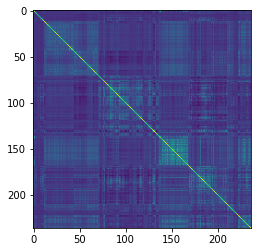

In [13]:
downloaded = drive.CreateFile({'id':"1WP4_9bps-NbX6GNBnhFu8itV3y1jriJL"})
downloaded.GetContentFile('FC.npy')
plt.imshow(np.load('FC.npy'))
plt.show()

## Set parameter

In [15]:
num_classes = 100
k = 5 # (3, 5, 10, 20)
batch_size = 4
epochs = 100
l2_reg = 1e-4
dp = 0.5
lr = 1e-4

print('dp:', dp)
print('l2:', l2_reg)
print('batch_size:', batch_size)
print('epochs:', epochs)
print('lr:', lr)

dp: 0.5
l2: 0.0001
batch_size: 4
epochs: 100
lr: 0.0001


## Train model

In [16]:
model = get_model(
    graph_path='FC.npy', 
    kernels=[8,8,8,16,32,32], 
    k=k, 
    l2_reg=l2_reg, 
    dp=dp,
    num_classes=num_classes, 
    weight_path=None, 
    skip=[0,0])
model.summary()

model.compile(loss=['categorical_crossentropy'], 
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                                              patience=10, min_lr=1e-6)
lr_hist = []
class Lr_record(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        tmp = K.eval(model.optimizer.lr)
        lr_hist.append(tmp)
        print('Ir:', tmp)
lr_record = Lr_record()
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpointer = keras.callbacks.ModelCheckpoint(monitor='val_acc', filepath='tmp.hdf5', 
                                                verbose=1, save_best_only=True)


load graph: FC.npy
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             (None, 100, 236, 1)  0                                            
__________________________________________________________________________________________________
graph (InputLayer)              (236, 5)             0                                            
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, 236, 5)       0           graph[0][0]                      
                                                                 points[0][0]                     
__________________________________________________________________________________________________
lambda_32 (Lambda)              (None, 100, 236, 5,  0           points[0][0]             

In [ ]:
model_history = model.fit(x_train, y_train,
                            shuffle=True,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            callbacks=[checkpointer, lr_record, reduce_lr, earlystop])

## Test on a pre-trained model

In [17]:
downloaded = drive.CreateFile({'id':"1KePCfQOt1hk6TfL98Y4qnsFvdTSYPijh"})
downloaded.GetContentFile('model_k_5.hdf5')

### On random data

In [19]:
k = 5
model_val = get_model(
    graph_path='FC.npy', 
    kernels=[8,8,8,16,32,32], 
    k=k, 
    l2_reg=0, 
    dp=0,
    num_classes=100, 
    weight_path='model_k_5.hdf5', 
    skip=[0,0])

model_val.compile(loss=['categorical_crossentropy'], 
              optimizer=keras.optimizers.Adam(lr=0),
              metrics=['accuracy'])

test_tmp1 = model_val.evaluate(x=x_test_random, y=y_train_random_100, batch_size=4,verbose=1)
print('Test acc:', test_tmp1[1])
# Test acc close to the random chance (1%, 100 categories)

load graph: FC.npy
Load weight: model_k_5.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 46s 458ms/step
Test acc: 0.0


### With random FC graph

In [20]:
k = 5
model_random = get_model(
    graph_path='FC_random.npy', 
    kernels=[8,8,8,16,32,32], 
    k=k, 
    l2_reg=0, 
    dp=0,
    num_classes=num_classes, 
    weight_path='model_k_5.hdf5', 
    skip=[0,0])

model_random.compile(loss=['categorical_crossentropy'], 
              optimizer=keras.optimizers.Adam(lr=0),
              metrics=['accuracy'])

test_tmp0 = model_random.evaluate(x=x_test, y=y_test, batch_size=4,verbose=1)
print('Test acc:', test_tmp0[1])
# Test acc is around 5% (random: 1%).

load graph: FC_random.npy
Load weight: model_k_5.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1200/1200 [==============================] - 538s 448ms/step
Test acc: 0.045


### With group FC graph

In [21]:
k = 5
model_val = get_model(
    graph_path='FC.npy', 
    kernels=[8,8,8,16,32,32], 
    k=k, 
    l2_reg=0, 
    dp=0,
    num_classes=num_classes, 
    weight_path='model_k_5.hdf5', 
    skip=[0,0])

model_val.compile(loss=['categorical_crossentropy'], 
              optimizer=keras.optimizers.Adam(lr=0),
              metrics=['accuracy'])

test_tmp1 = model_val.evaluate(x=x_test, y=y_test, batch_size=4,verbose=1)
print('Test acc:', test_tmp1[1])
# Test acc is 98.3% (random: 1%).

load graph: FC.npy
Load weight: model_k_5.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1200/1200 [==============================] - 537s 448ms/step
Test acc: 0.9833333333333333
